## Embeddings extraction
On this notebook I will compare a target image to a pool of other images, this simulates the process where a customer uploads his picture that will be compared to the shop's catalogue images.  

The strategy will be to use a neural network already trained on the imagenet dataset and use it to extract the embeddings of all images in our store catalogue. These embeddings will be stored and when a new image is uploaded to the server the embedding of that image will be extracted and compared to the other ones where the "n" most similar images will be returned. To compare the images cosine similarity will be used.

For efficiency purposes embeddings are run only once and exported to a csv file, then the file is loaded into memory.

### TO DO
- Turn into python script
- Connect to flask app

Scalability: 400k embeddings estimated = 150GB & 17hours (PCA/Smaller feature layer/)

In [1]:
%matplotlib inline
import os
import sys
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib.image as mpimg
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook as tqdm
from keras.applications.inception_v3 import InceptionV3 , preprocess_input
from keras.preprocessing import image
from scipy.spatial.distance import cdist
# pip install h5py==2.8.0rc1 to disable the h5py warning

Using TensorFlow backend.


In [2]:
model = InceptionV3(weights="imagenet", include_top=False) # https://keras.io/applications/

In [3]:
# Returns the array representation of all images in the path specified in raw format and preprocessed format for the NN
def preprocess_img(catalogue_path): #read https://stackoverflow.com/questions/47555829/preprocess-input-method-in-keras
    img_paths = os.listdir(catalogue_path)
    raw_imgs = [image.load_img(os.path.join(catalogue_path, img_path), target_size=(250,250)) for img_path in img_paths]
    proc_imgs = np.array([preprocess_input(np.expand_dims(image.img_to_array(img), axis=0)[0]) for img in raw_imgs])
    return raw_imgs, proc_imgs

In [4]:
catalogue_path = "./dummy_dataset_3"
target_path = "./target_image"

img_all_raw, img_all = preprocess_img(catalogue_path)

In [14]:
#calculates the embeddings
def embeddings(img_arrays, write=True):
    if write==True:
        embeddings_img = []
        with tqdm(total=len(img_arrays), file=sys.stdout) as pbar:
            for n, img in enumerate(img_arrays):
                embeddings_img.append(model.predict(np.expand_dims(img, axis=0)).flatten())
                pbar.set_description("done: %d" % (1 + n))
                pbar.update(1)
        embeddings_img = np.array(embeddings_img, np.float16) #float16 reduces decimal precision but saves disk space

        print("writing to file")
        pd.DataFrame(embeddings_img,columns=None).to_csv("embeddings.csv", index=False, header=False)
    else:
        embeddings_img = np.array([model.predict(np.expand_dims(img, axis=0)).flatten() for img in img_arrays])
        return embeddings_img

In [16]:
# %%time
# embeddings(img_all, write=True) #ONLY RUN THE FIRST TIME TO SAVE THE EMBEDDINGS TO DISK

In [7]:
%%time 
#using np to load all embeddings (fastest way), will initially fill up all ram
embs_catalogue = np.loadtxt(open("./embeddings.csv",'rb'),delimiter=",",skiprows=0) 

Wall time: 2min 42s


In [8]:
def target_embedding(target_path, target_img, embs_catalogue, method="cosine"):
    list_images = os.listdir(target_path) #read all images in target folder
    raw_imgs, proc_imgs = preprocess_img(target_path) #preprocessing target folder
    target_index = list_images.index(target_img) #finds index in case there is > 1 photo
    embs_target = embeddings(proc_imgs, write=False) #embedding
    embs_target = embs_target[target_index]
    
    distance = cdist(embs_catalogue, embs_target.reshape(1,-1), "cosine") #cosine distance between target and catalogue
    rank = np.argsort(distance.ravel()) #ranks by similarity, returns the indices that would sort the distance array
    return rank

def show_image(ids, imgs_arrays, target_img):
    print("Target image:")
    plt.imshow(mpimg.imread(target_img))
    plt.axis("off")
    plt.show()   

    print("Top {} similar images".format(len(ids)))
    fig = plt.figure(figsize=(20,20))
    gs = gridspec.GridSpec(1, len(ids))
    for i in range(len(ids)):
        ax = fig.add_subplot(gs[0, i])
        ax.imshow(imgs_arrays[ids[i]])
        ax.axis("off")
    plt.show()

Target image:


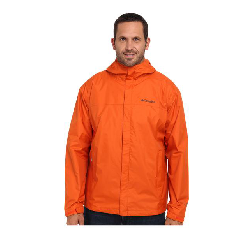

Top 10 similar images


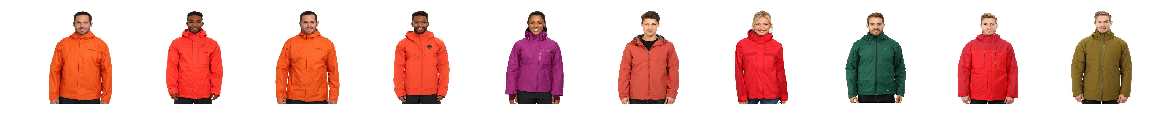

Wall time: 2.69 s


In [18]:
%%time
target_img = "p8247810_s2516046_v0.jpg"
rank = target_embedding(target_path, target_img, embs_catalogue, "cosine")
n = 10
show_image(rank[0:n], img_all_raw, os.path.join(target_path, target_img)) #img 172

Target image:


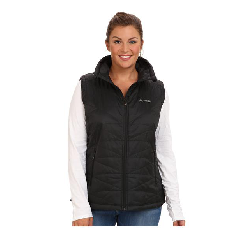

Top 10 similar images


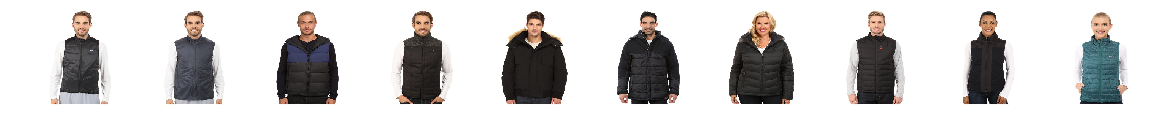

Wall time: 1.62 s


In [19]:
%%time
target_img = "p7974976_s2254006_v0.jpg"
rank = target_embedding(target_path, target_img, embs_catalogue, "cosine")
n = 10
show_image(rank[0:n], img_all_raw, os.path.join(target_path, target_img)) #img 65

Target image:


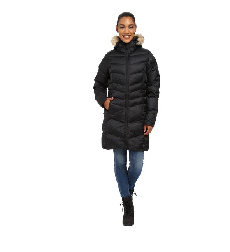

Top 10 similar images


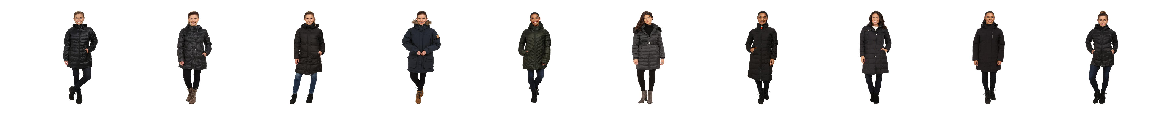

Wall time: 1.48 s


In [12]:
%%time
target_img = "p7545592_s3176823_v0.jpg"
rank = target_embedding(target_path, target_img, embs_catalogue, "cosine")
n = 10
show_image(rank[0:n], img_all_raw, os.path.join(target_path, target_img)) #img 21

Target image:


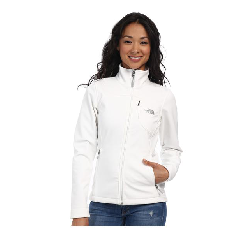

Top 10 similar images


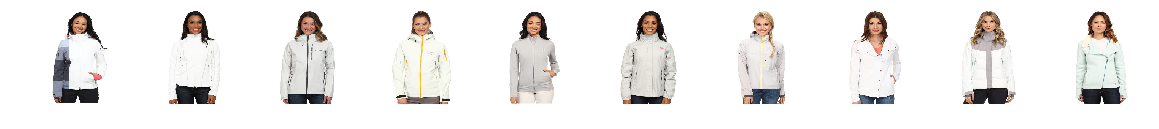

Wall time: 1.44 s


In [13]:
%%time
target_img = "p7258531_s2988598_v0.jpg"
rank = target_embedding(target_path, target_img, embs_catalogue, "cosine")
n = 10
show_image(rank[0:n], img_all_raw, os.path.join(target_path, target_img)) #img 6

Target image:


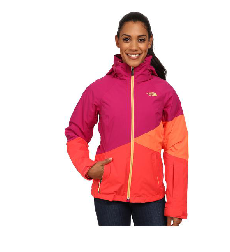

Top 10 similar images


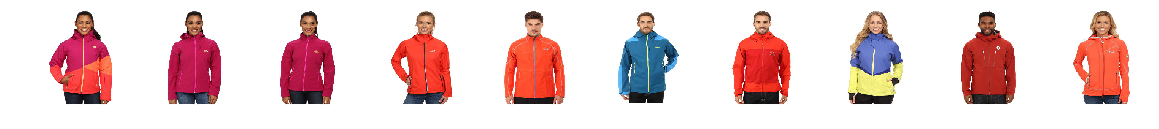

Wall time: 1.52 s


In [33]:
%%time
target_img = "p8558827_s3236063_v0.jpg"
rank = target_embedding(target_path, target_img, embs_catalogue, "cosine")
n = 10
show_image(rank[:n], img_all_raw, os.path.join(target_path, target_img)) #img 6